# Generate trajectories

In [1]:
from marlenv import Episode
from marlenv.wrappers import RLEnvWrapper
from marl.agents import RandomAgent
from lle import LLE
import marl
from tqdm import tqdm
import numpy as np
from dataclasses import dataclass


@dataclass
class EpData:
    episode: Episode
    n_gems: int
    exit_rate: float
    length: int
    seed: int

    def __init__(self, episode: Episode, seed: int):
        self.episode = episode.padded(78)
        self.n_gems = int(episode.metrics["gems_collected"])
        self.exit_rate = episode.metrics["exit_rate"]
        self.length = len(episode)
        self.seed = seed

    @property
    def states(self):
        states = np.array(self.episode.all_states)
        return states.flatten()


def collect_random_episodes(env: RLEnvWrapper, n_runs: int):
    lle = env.unwrapped
    assert isinstance(lle, LLE)
    agent = RandomAgent(env)
    res = list[EpData]()
    for i in range(n_runs):
        obs, state = env.reset()
        is_terminal = False
        episode = Episode.new(obs, state)
        while not is_terminal:
            action = agent.choose_action(obs)
            step = env.step(action)
            episode.add(step, action)
            is_terminal = step.is_terminal
            obs = step.obs
        res.append(EpData(episode, i))
    return res

def collect_episodes(logdir: str, time_step: int):
    exp = marl.Experiment.load(logdir)
    episodes = list[EpData]()
    for run in tqdm(exp.runs):
        for test_num in range(run.n_tests):
            replay = exp.replay_episode(run.seed, time_step, test_num)
            episodes.append(EpData(replay.episode, run.seed))
    return episodes

# 3D plot
Plot according to the number of gems collected, the exit rate and the number of steps taken

In [8]:
import matplotlib.pyplot as plt

def plot_2d(datapoints: dict[str, np.ndarray], xlabel: str, ylabel: str):
    """2D plot where each metric is a dimension"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for logdir, data in datapoints.items():
        ax.scatter(data[:, 0], data[:, 1], label=logdir, alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()

def plot_3d(datapoints: dict[str, np.ndarray], xlabel: str, ylabel: str, zlabel: str):
    """3D plot where each metric is a dimension"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for logdir, data in datapoints.items():
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], label=logdir)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel) # type: ignore
    plt.legend()
    plt.show()

# Fit PCA

In [3]:
from sklearn import decomposition

def get_pca(episodes: dict[str, list[EpData]], n_dims: int):
    pca = decomposition.PCA(n_components=n_dims)
    states = []
    for eps in episodes.values():
        for ep in eps:
            states.append(ep.states)
    pca_states = np.array(states)
    print(pca_states.shape)
    pca.fit(pca_states)
    return pca

In [10]:
from lle import LLE
logdirs = [
    "logs/baseline-vdn",
    "logs/randomized-lasers",
    "logs/randomized_starts",
    "logs/randomized_starts+lasers",
]

episodes = {logdir: collect_episodes(logdir, 1_000_000) for logdir in logdirs}
episodes["random"] = collect_random_episodes(LLE.level(6).builder().time_limit(78).build(), 30)
pca2 = get_pca(episodes, 2)
pca3 = get_pca(episodes, 3)

0it [00:00, ?it/s]

30it [00:08,  3.52it/s]
10it [00:02,  4.41it/s]
20it [00:05,  3.93it/s]
20it [00:04,  4.02it/s]

(110, 1264)
(110, 1264)


# Plots
2D & 3D with either metrics or PCA

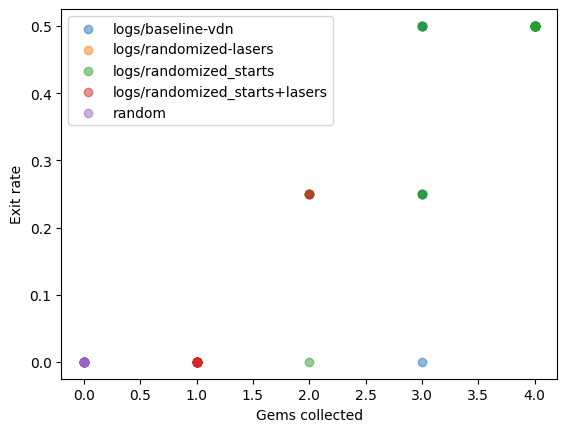

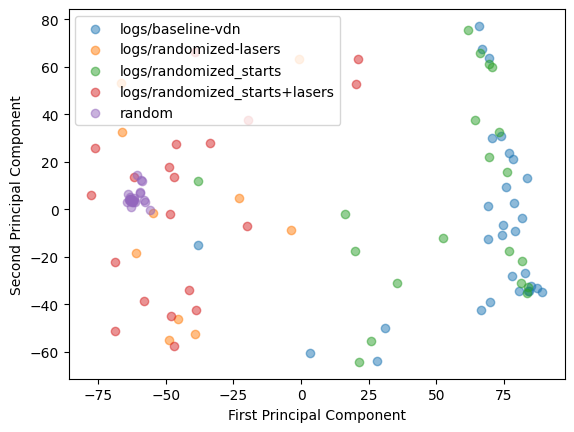

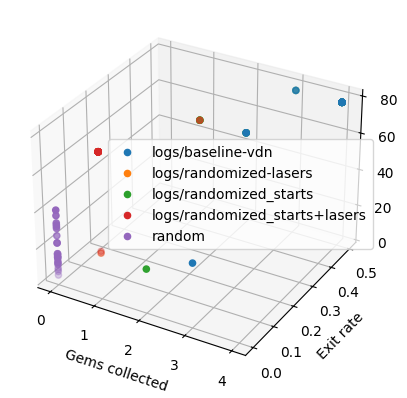

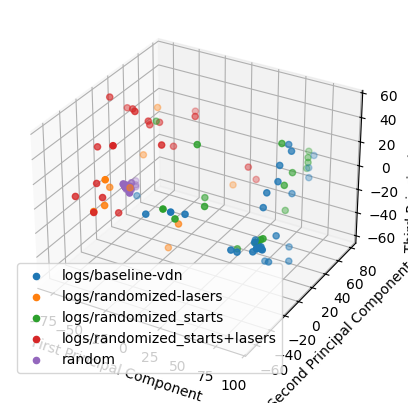

In [12]:
raw_states_datapoints = {logdir: np.array([e.states for e in es]) for logdir, es in episodes.items()}
metrics_datapoints = {logdir: np.array([[e.n_gems, e.exit_rate, e.length] for e in es]) for logdir, es in episodes.items()}
pca2_datapoints = {logdir: pca2.transform(raw_states_datapoints[logdir]) for logdir in episodes}
pca3_datapoints = {logdir: pca3.transform(raw_states_datapoints[logdir]) for logdir in episodes}

plot_2d(metrics_datapoints, "Gems collected", "Exit rate")
plot_2d(pca2_datapoints, "First Principal Component", "Second Principal Component")

plot_3d(metrics_datapoints, "Gems collected", "Exit rate", "Length")
plot_3d(pca3_datapoints, "First Principal Component", "Second Principal Component", "Third Principal Component")

# K-means clustering

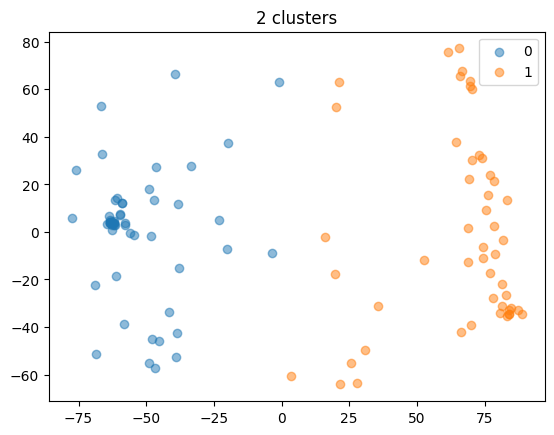

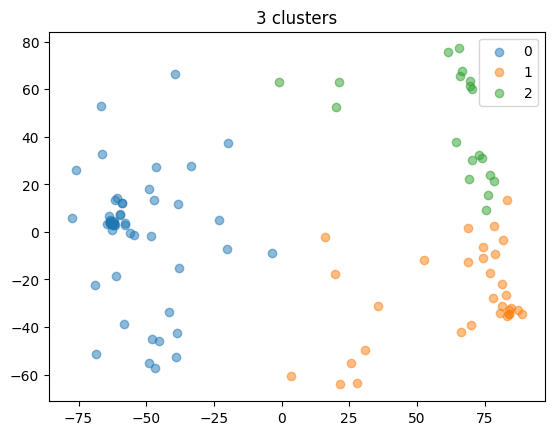

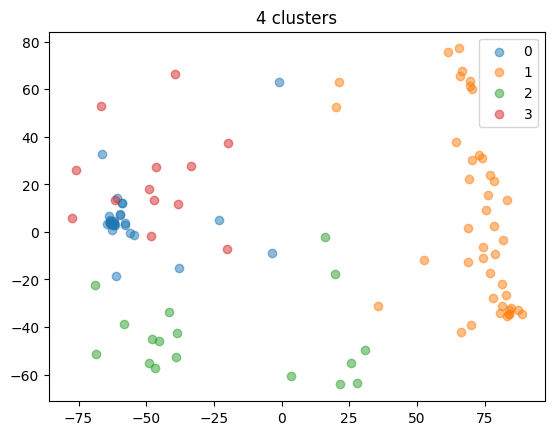

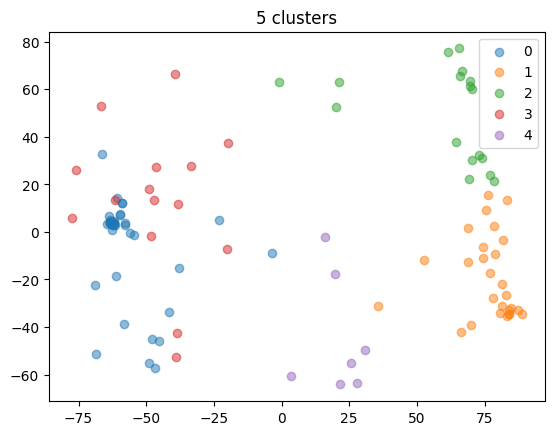

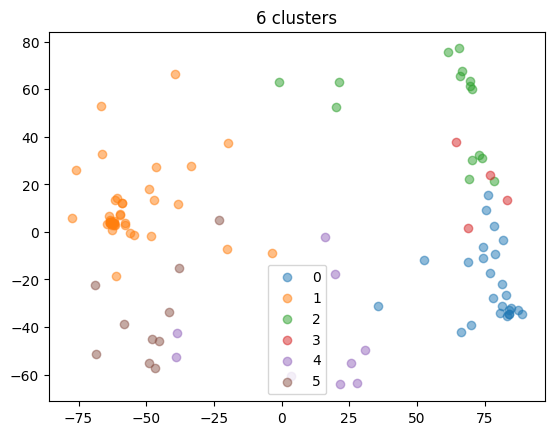

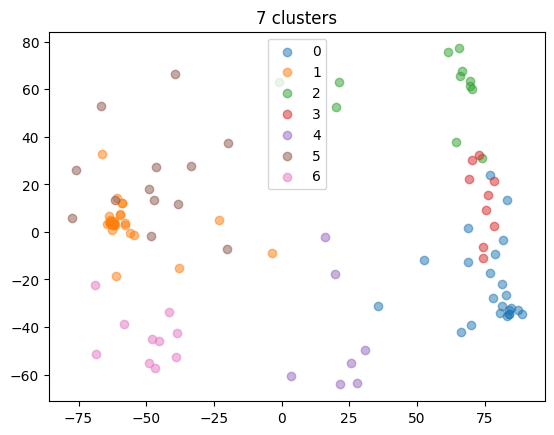

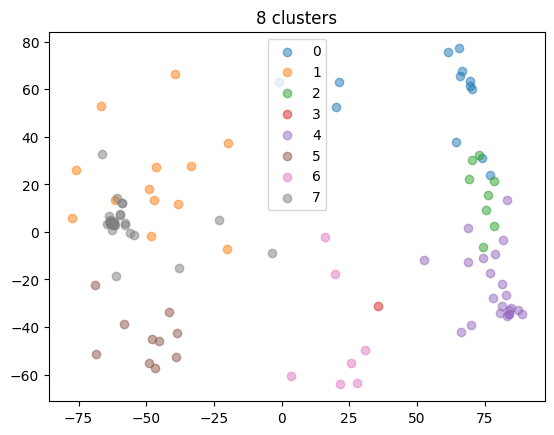

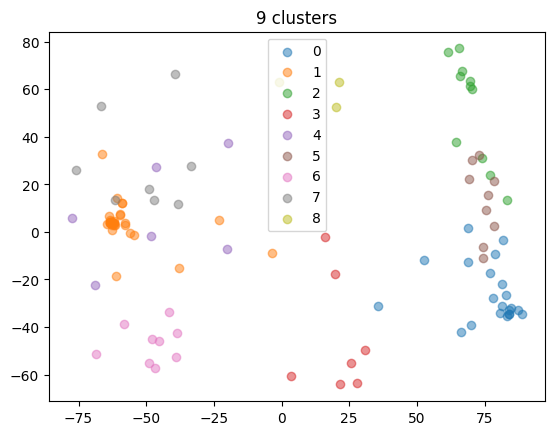

In [20]:
from sklearn.cluster import KMeans

def cluster_fit_predict(data: dict[str, np.ndarray], n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters)
    datapoints = np.concatenate([v for v in data.values()])
    kmeans.fit(datapoints)
    return { logdir: kmeans.predict(data[logdir]) for logdir in data }
    
for n_clusters in range(2, 10):
    labels_by_logdir = cluster_fit_predict(raw_states_datapoints, n_clusters)
    by_label = {label: [] for label in range(n_clusters)}
    for logdir, labels in labels_by_logdir.items():
        for pos, label in zip(pca2_datapoints[logdir], labels):
            by_label[label].append(pos)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label, positions in by_label.items():
        positions = np.array(positions)
        ax.scatter(positions[:, 0], positions[:, 1], label=label, alpha=0.5)
    ax.set_title(f"{n_clusters} clusters")
    plt.legend()
    plt.show()
    




# PCA of NN weights

In [ ]:
import marl 
import numpy as np


def get_runs_weights(logdir: str):
    exp = marl.Experiment.load(logdir)
    weights_by_run = dict[int, np.ndarray]()
    weights_list = []
    for i, run in enumerate(exp.runs):
        if i > 5:
            break
        run_weights = []
        for d in run.test_dirs:
            exp.agent.load(d)5
            test_step_weights = []
            for network in exp.agent.networks:
                for name, params in network.named_parameters():
                    if "weight" in name:
                        w = params.detach().numpy().flatten()
                        test_step_weights.append(w)
            run_weights.append(np.concatenate(test_step_weights))
        run_weights = np.array(run_weights)
        weights_list.append(run_weights)
        weights_by_run[run.seed] = run_weights
        
    return np.array(weights_list)

In [22]:
import matplotlib.pyplot as plt
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
all_runs_weights = get_runs_weights("logs/pbrs-baseline")


print(all_runs_weights.shape)
pca.fit(all_runs_weights.reshape(-1, all_runs_weights.shape[-1]))

(6, 200, 235648)


PCA(n_components=2)

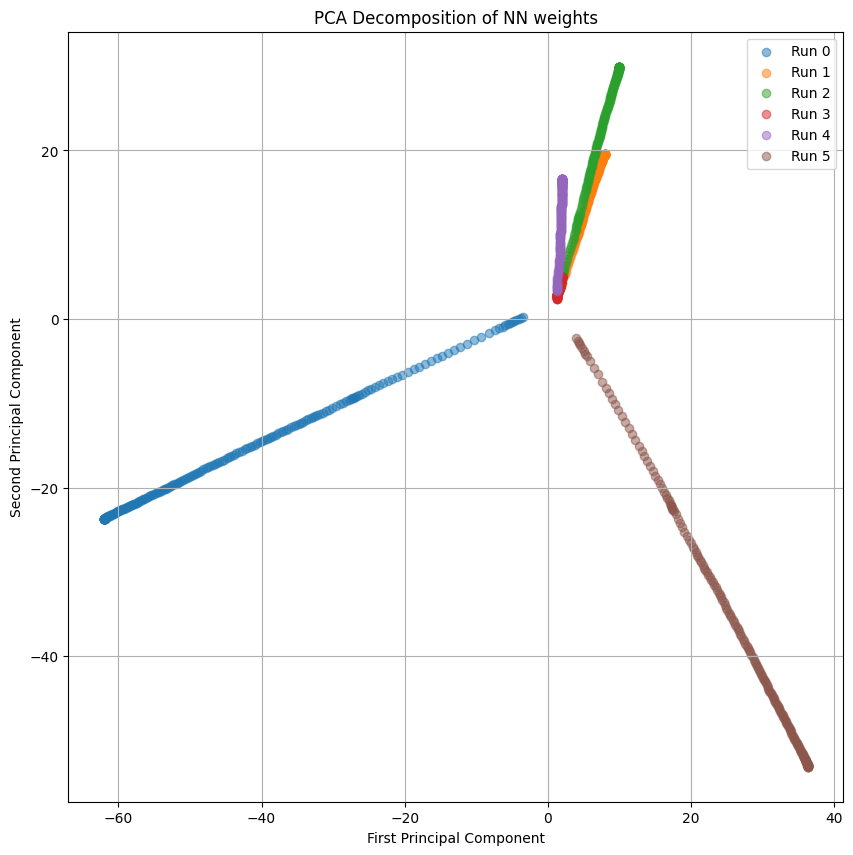

In [23]:
plt.figure(figsize=(10, 10))
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Decomposition of NN weights")


transform_by_run = {seed: pca.transform(weights) for seed, weights in enumerate(all_runs_weights)}
for seed, transformed in transform_by_run.items():
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, label=f"Run {seed}")
# plt.scatter(all_transformed[:, 0], all_transformed[:, 1], alpha=0.5)


plt.grid(True)
plt.legend()
# plt.savefig("pca.png")
plt.show()


# Cluster by distribution
We randomly sample the World states and compute the corresponding NN output.

In [1]:
from lle import World, WorldState
from itertools import product
import matplotlib.pyplot as plt
import numpy as np


def sample_world_states(world: World, n_samples: int) -> set[WorldState]:
    all_positions = set(product(range(world.height), range(world.width)))
    wall_pos = set(world.wall_pos)
    laser_pos = set(laser.pos for laser in world.lasers)
    valid_positions = list(all_positions - wall_pos - laser_pos)
    gems_pos = list(gem.pos for gem in world.gems)
    states = set[WorldState]()
    while len(states) < n_samples:
        indices = np.random.choice(np.arange(len(valid_positions)), world.n_agents, replace=False)
        positions = [valid_positions[i] for i in indices]
        gems_collected = [pos in positions for pos in gems_pos]
        state = WorldState(positions, gems_collected)
        # Check that the state is valid
        world.set_state(state)
        states.add(state)
    return states

In [17]:
import marl
from tqdm import tqdm
from lle import LLE
from marlenv.wrappers import RLEnvWrapper
from typing import Iterable
import torch


def get_qvalues(logdir: str, states: Iterable[WorldState]):
    """Compute the agent-wise Qvalues"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    exp = marl.Experiment.load(logdir)
    agent = exp.agent_at(1_000_000).to(device)
    assert isinstance(agent, marl.agents.DQN)
    env = exp.env
    assert isinstance(env, RLEnvWrapper)
    lle = env.unwrapped
    assert isinstance(lle, LLE)
    world = lle.world
    run_qvalues = []
    for state in tqdm(states):
        world.set_state(state)
        obs = env.get_observation()
        x = agent.qvalues(obs).numpy(force=True)
        run_qvalues.append(x)
    return np.array(run_qvalues)


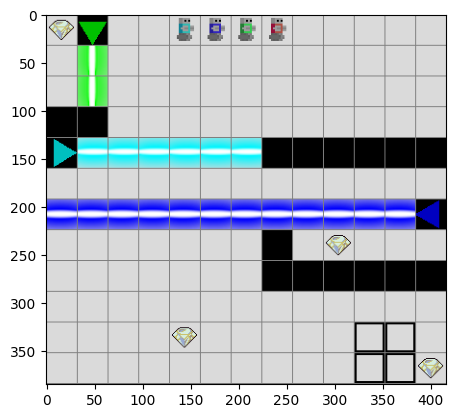

In [ ]:
from lle import World 

logdirs = ["logs/pbrs-baseline", "logs/baseline-vdn"]
world = World.level(6)
plt.imshow(world.get_image())
ep_data = sample_world_states(world, 10_000)

In [ ]:
qvalues = {logdir: get_qvalues(logdir, ep_data) for logdir in logdirs}

100%|██████████| 10000/10000 [00:09<00:00, 1006.77it/s]


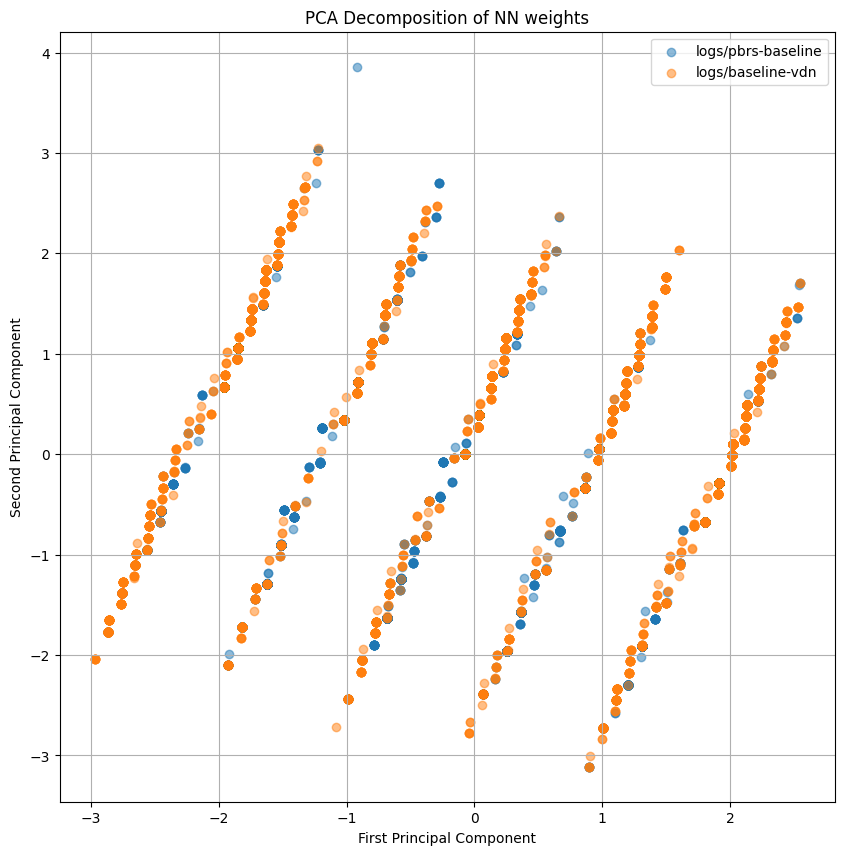

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)

data_by_logdir = {logdir: np.argmax(qvalues, axis=-1) for logdir, qvalues in qvalues.items()}
pca_inputs = np.concatenate(list(data_by_logdir.values()))
pca.fit(pca_inputs)

plt.figure(figsize=(10, 10))
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Decomposition of agent-wise actions")

for logdir, metrics_datapoints in data_by_logdir.items():
    transformed = pca.transform(metrics_datapoints)
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, label=logdir)

plt.grid(True)
plt.legend()
plt.show()

In [25]:
taken_action = {logdir: np.argmax(qvalues, axis=-1) for logdir, qvalues in qvalues.items()}
equals = taken_action["logs/pbrs-baseline"] == taken_action["logs/baseline-vdn"]
proportion_equal = np.mean(equals)
proportion_equal

np.float64(0.32995)